In [ ]:
!pip install shap
!pip install xgboost
!pip install lime
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install seaborn
!pip install matplotlib
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux"

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

import shap
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = data.copy()

In [ ]:
'''# 'USE_AM' 컬럼을 추가하여 체크카드 사용량이 신용카드 사용량보다 많은 경우 , 반대의 경우 0으로 설정
df['USE_AM'] = df.apply(lambda row: 1 if row['CRDSL_USE_AM'] < row['CNF_USE_AM'] else 0 if row['CRDSL_USE_AM'] > row['CNF_USE_AM'] else None, axis=1)

# 'USE_AM'이 None인 경우(사용량이 같은 경우)를 드랍
df = df.dropna(subset=['USE_AM'])'''

In [ ]:
df = df.drop(index=df[(df['CRDSL_USE_AM'] != 0) & (df['CNF_USE_AM'] != 0)].index)
# CNF_USE_AM이 0이면 0, 그렇지 않으면 1로 인코딩
df['USE_AM'] = df['CNF_USE_AM'].apply(lambda x: 0 if x == 0 else 1) #체크카드만 사용했으면 1, 신용카드만 사용했으면 0

In [ ]:
# CRDSL_USE_AM와 CNF_USE_AM 컬럼 드롭
df = df.drop(columns=['CRDSL_USE_AM', 'CNF_USE_AM'])

df = df[df['AGE'] != '기타'] #int형 변환을 위해 기타 드랍
df['AGE'] = df['AGE'].astype(int) # 연령 유형을 int로 변환
df['MBR_RK'] = df['MBR_RK'].astype(int) # 회원등급 int 변환(20~24)

df['ATT_YM'] = pd.to_datetime(df['ATT_YM'], format='%Y%m') #입회년월 타입 변경

# ATT_YM이 datetime64 형식이라면 이를 처리
# ATT_YM의 연도와 월을 추출하여 새로운 변수로 사용
df['ATT_YM_YEAR'] = df['ATT_YM'].dt.year
df['ATT_YM_MONTH'] = df['ATT_YM'].dt.month

# 원래의 ATT_YM 열은 사용하지 않음 (혹은 드롭)
df = df.drop(columns=['ATT_YM'])

# prompt: df['SEX_CD']=1은 0으로, 2는 1로 변경
df['SEX_CD'] = df['SEX_CD'].replace({1: 0, 2: 1})
df['SEX_CD'] = df['SEX_CD'].astype(int) # 성별 int변환(1남성 2여성)

df = df.dropna(subset=['HOUS_SIDO_NM']) #HOUS_SIDO_NM null값 제거

#df = df.dropna(subset=['LIFE_STAGE']) #LIFE_STAGE null값 제거
df['LIFE_STAGE'] = df['LIFE_STAGE'].fillna('unknown') #데이터 개수가 많으므로 no_info로 대체

encoder = LabelEncoder() #라벨 인코딩
df['LIFE_STAGE'] = encoder.fit_transform(df['LIFE_STAGE'])
df['HOUS_SIDO_NM'] = encoder.fit_transform(df['HOUS_SIDO_NM'])
df['BAS_YH']= encoder.fit_transform(df['BAS_YH'])
df['SEQ']= encoder.fit_transform(df['SEQ'])

In [ ]:
df['USE_AM'] = df['USE_AM'].astype(int) #int형으로 변환
df['DIGT_CHNL_REG_YN'] = df['DIGT_CHNL_REG_YN'].apply(lambda x: 1 if x == 'Y' else 0) #원핫인코딩
df['DIGT_CHNL_USE_YN'] = df['DIGT_CHNL_USE_YN'].apply(lambda x: 1 if x == 'Y' else 0)

Random Forest Accuracy: 0.8391739328455607
              precision    recall  f1-score   support

           0       0.86      0.93      0.89    615340
           1       0.77      0.59      0.67    234373

    accuracy                           0.84    849713
   macro avg       0.81      0.76      0.78    849713
weighted avg       0.83      0.84      0.83    849713

XGBoost Accuracy: 0.8349854597964254
              precision    recall  f1-score   support

           0       0.86      0.93      0.89    615340
           1       0.75      0.60      0.67    234373

    accuracy                           0.83    849713
   macro avg       0.81      0.76      0.78    849713
weighted avg       0.83      0.83      0.83    849713



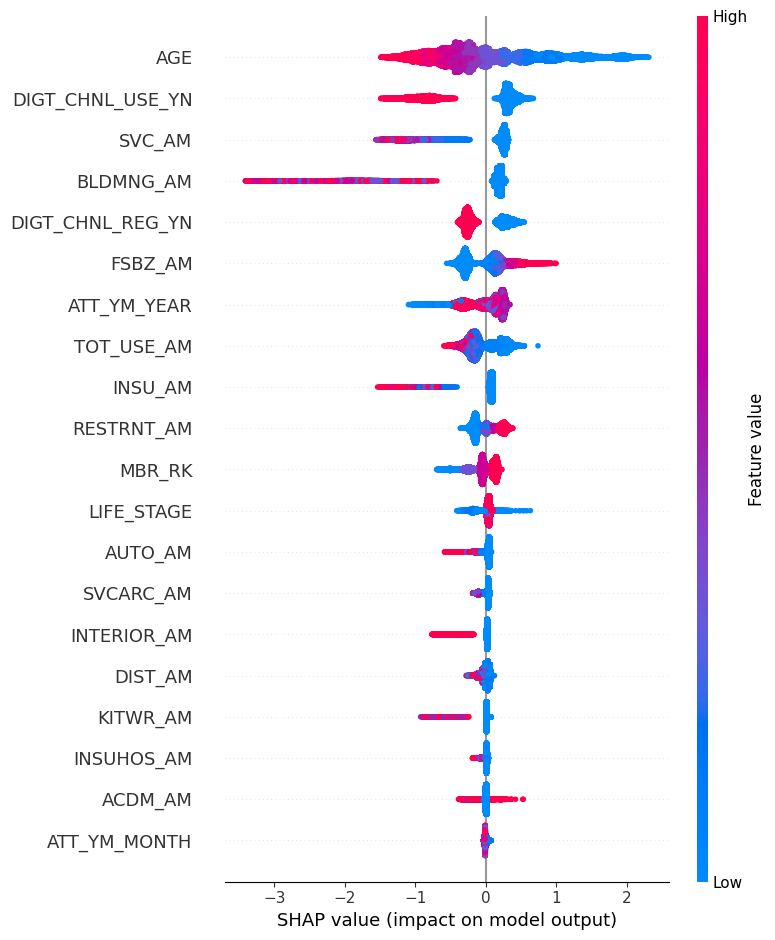

In [ ]:
'''# Feature와 Target 변수 선택
X = df.drop(columns=['USE_AM'])
y = df['USE_AM']  # 타겟 변수

# 데이터의 100% 사용
sample_fraction = 1
X_sample = X.sample(frac=sample_fraction, random_state=42)
y_sample = y.loc[X_sample.index]

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X_test를 DataFrame으로 변환하고 원래의 컬럼명을 유지
X_test_df = pd.DataFrame(X_test, columns=X_sample.columns)

# 랜덤 포레스트 모델 초기화 및 학습
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행 및 평가
y_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# XGBoost 모델 초기화 및 학습
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행 및 평가
y_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 데이터 샘플링 (10%의 데이터만 사용)
X_sample = X_test_df.sample(frac=0.1, random_state=42)

# SHAP 값 계산
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

# SHAP 값 시각화 (컬럼명 유지)
shap.summary_plot(shap_values, X_sample)
'''

In [ ]:
# Feature와 Target 변수 선택
X = df.drop(columns=['USE_AM'])
y = df['USE_AM']  # 타겟 변수

# 데이터의 100% 사용
sample_fraction = 1
X_sample = X.sample(frac=sample_fraction, random_state=42)
y_sample = y.loc[X_sample.index]

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X_test를 DataFrame으로 변환하고 원래의 컬럼명을 유지
X_test_df = pd.DataFrame(X_test, columns=X_sample.columns)

# 랜덤 포레스트 모델 초기화 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행 및 평가
y_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# SHAP 값 계산
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

# SHAP 값 시각화 (컬럼명 유지)
shap.summary_plot(shap_values, X_sample)

In [ ]:
import joblib

joblib.dump(rf_model, 'random_forest_model.joblib')